<a href="https://colab.research.google.com/github/iraidaantropova/machine_L/blob/main/HW5_SinitsaI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Урок 5. Задача оттока: варианты постановки, возможные способы решения

1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)

2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)

3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты.

4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3

5. (опционально) Еще раз провести оценку экономической эффективности

In [2]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
df = pd.read_csv('churn_data.csv')
print(df.shape)
df.head()

(10000, 14)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [6]:
#разделяю данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

In [7]:
#собираю простой pipeline, также необходимо написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]

class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [8]:
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [9]:
#задаю списки признаков
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

Нужно под каждый признак создать трансформер и объединить их в список (делаю это в цикле)

In [10]:
from sklearn.preprocessing import StandardScaler

final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))

for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('scaler', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))

In [11]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

In [12]:
#есть пайплайн, который готовит признаки для моделирования.
#Добавляю модель (случайный лес)

from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])

In [13]:
#обучим наш пайплайн
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Tenu...
                                                                  NumberSelector(key='Balance')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('NumOfProducts',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='NumOfProducts')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('EstimatedSalary',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='EstimatedSalary')),
                                                                 ('scaler',
                                                                  StandardScaler())]))])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [14]:
# прогноз для тестовой выборки
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.37, 0.26, 0.17, 0.02, 0.02, 0.67, 0.04, 0.12, 0.15, 0.75])

In [15]:
#Для того, чтобы перейти от вероятностей к меткам классов,
#нужно подобрать порог, после которого можносчитать,
#что объект можно отнести к классу 1 (если вероятность больше порога - размечаю объект как класс 1, если нет - класс 0)


from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix],
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.380000, F-Score=0.641, Precision=0.654, Recall=0.629


In [16]:
#матрица ошибок

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1833  158]
 [ 195  314]]


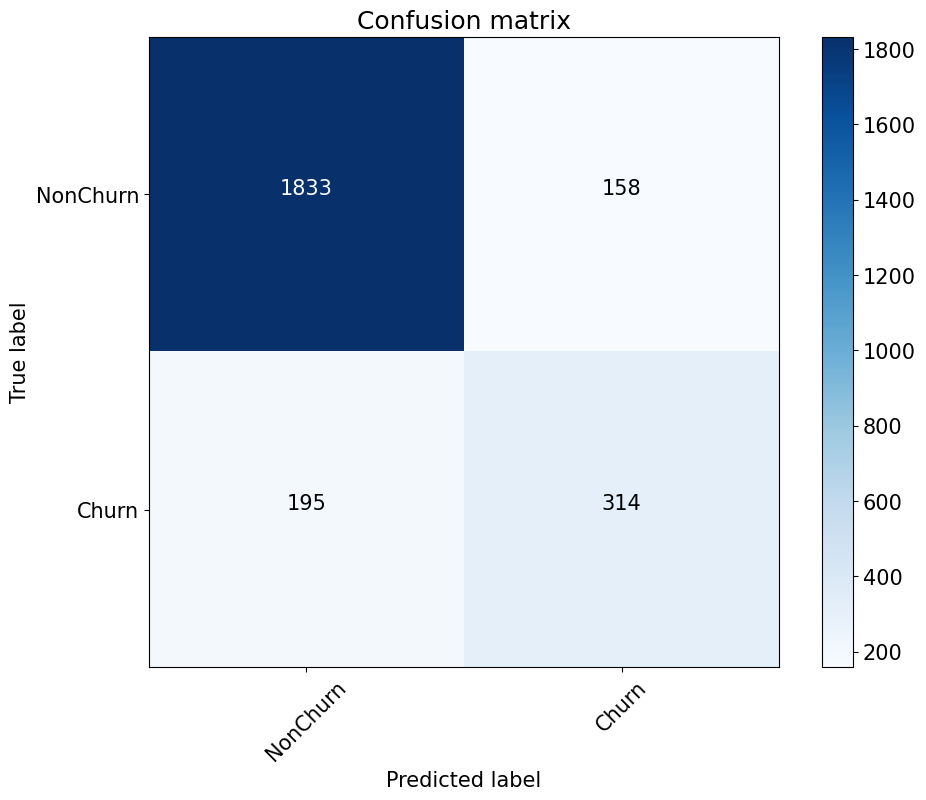

In [17]:
#ранее "оптимальный" порог был найден , когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [18]:
#Добавляю модель (градиентный бустинг)

from sklearn.ensemble import GradientBoostingClassifier
pipeline_gb = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(random_state = 42)),
])

In [20]:
#обучаю наш пайплайн
pipeline_gb.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Tenu...
                                                                  NumberSelector(key='Balance')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('NumOfProducts',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='NumOfProducts')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('EstimatedSalary',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='EstimatedSalary')),
                                                                 ('scaler',
                                                                  StandardScaler())]))])),
                ('classifier', GradientBoostingClassifier(random_state=42))])

In [41]:
# прогноз для тестовой выборки
preds_gb = pipeline_gb.predict_proba(X_test)[:, 1]
preds[:10]

precision_gb, recall_gb, thresholds_gb = precision_recall_curve(y_test, preds_gb)

fscore_gb = (2 * precision_gb * recall_gb) / (precision_gb + recall_gb)
# locate the index of the largest f score
ix_gb = np.argmax(fscore_gb)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_gb[ix],
                                                                        fscore_gb[ix],
                                                                        precision_gb[ix],
                                                                        recall_gb[ix]))

Best Threshold=0.408508, F-Score=0.646, Precision=0.704, Recall=0.597


Confusion matrix, without normalization
[[1863  128]
 [ 206  303]]


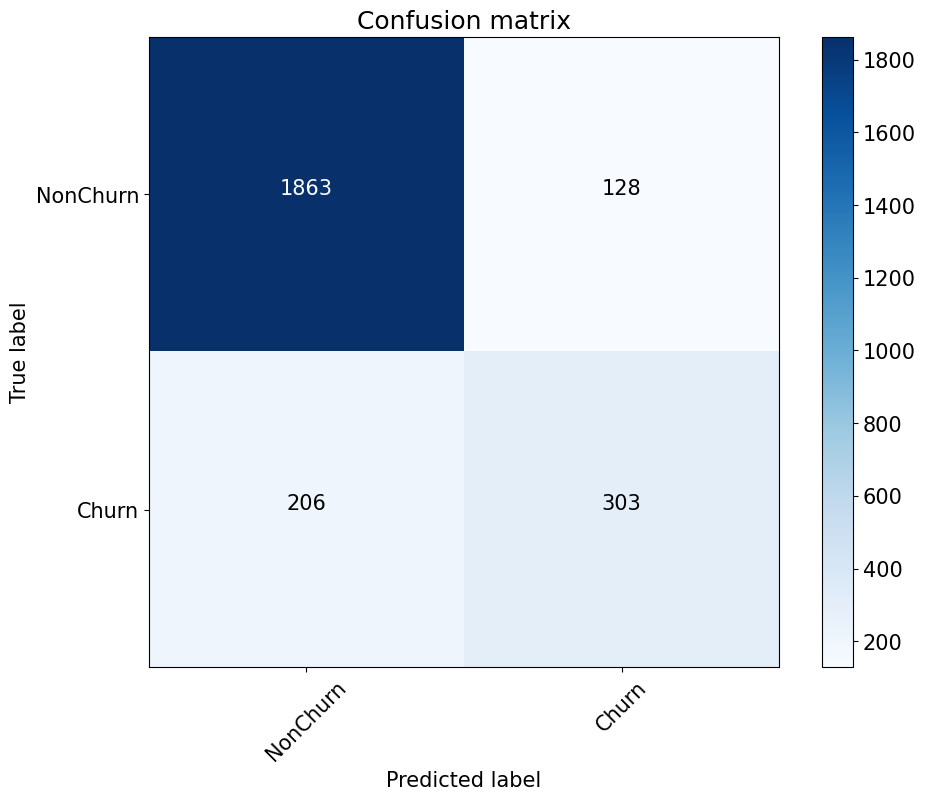

In [42]:
#ранее "оптимальный" порог был найден , когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_gb = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [43]:
#Для логистической регрессии предварительно стандартизирую числовые признаки,
#и применяю One Hot Encoder к категориальным.

from sklearn.preprocessing import StandardScaler

categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))

for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('scaler', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))


feats = FeatureUnion(final_transformers)

In [44]:
#добавляю модель логистической регрессии

pipeline_LR = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])

In [45]:
#обучение

pipeline_LR.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Tenu...
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='Balance')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('NumOfProducts',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='NumOfProducts')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('EstimatedSalary',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='EstimatedSalary')),
                                                                 ('scaler',
                                                                  StandardScaler())]))])),
                ('classifier', LogisticRegression(random_state=42))])

In [46]:
#прогноз для тестовой выборки
preds_LR = pipeline_LR.predict_proba(X_test)[:, 1]

precision_LR, recall_LR, thresholds_LR = precision_recall_curve(y_test, preds_LR)

fscore_LR = (2 * precision_LR * recall_LR) / (precision_LR + recall_LR)
# locate the index of the largest f score
ix_LR = np.argmax(fscore_LR)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_LR[ix_LR],
                                                                        fscore_LR[ix_LR],
                                                                        precision_LR[ix_LR],
                                                                        recall_LR[ix_LR]))

Best Threshold=0.289522, F-Score=0.510, Precision=0.462, Recall=0.568


Confusion matrix, without normalization
[[1863  128]
 [ 206  303]]


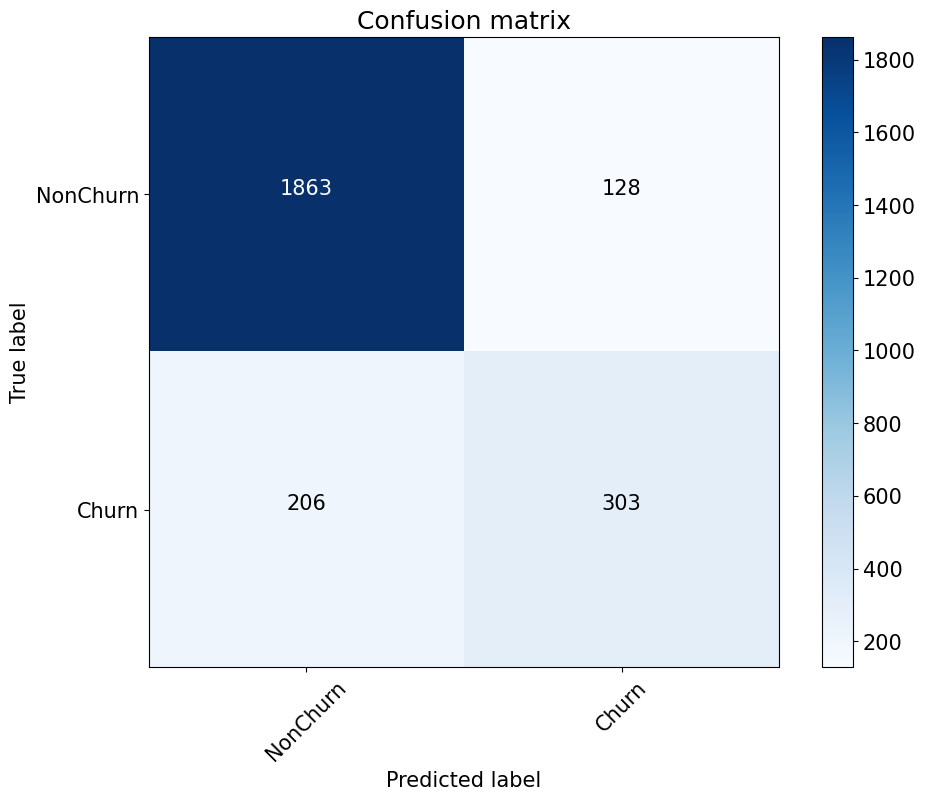

In [47]:
#ранее "оптимальный" порог был найден , когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_LR = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [49]:
metrics_df = pd.DataFrame([['RandomForest', precision[ix], recall[ix], fscore[ix], roc_auc_score(y_test, preds)],
                          ['GradientBoosting', precision_gb[ix_gb], recall_gb[ix_gb], fscore_gb[ix_gb], roc_auc_score(y_test, preds_gb)],
                          ['LogisticRegression', precision_LR[ix_LR], recall_LR[ix_LR], fscore_LR[ix_LR], roc_auc_score(y_test, preds_LR)]],
                          columns=['Model', 'precision', 'recall', 'fscore', 'roc_auc_score'])
metrics_df

,Model,precision,recall,fscore,roc_auc_score
0,RandomForest,0.703704,0.59725,0.646121,0.875746
1,GradientBoosting,0.703704,0.59725,0.646121,0.875746
2,LogisticRegression,0.462400,0.56778,0.509700,0.772077


в сравнении 2 модели показали себя одинаково хорошо, для решения 3 задания буду использовать модель градиентного бустинга


In [50]:
# градиентный бустинг
TN = cnf_matrix_gb[0][0]
FP = cnf_matrix_gb[0][1]
FN = cnf_matrix_gb[1][0]
TP = cnf_matrix_gb[1][1]

retain_sum_gb = (FP + TP) * 1
income_gb = TP * 2

income_gb - retain_sum_gb

175

In [51]:
# логистическая регрессия
TN = cnf_matrix_LR[0][0]
FP = cnf_matrix_LR[0][1]
FN = cnf_matrix_LR[1][0]
TP = cnf_matrix_LR[1][1]

retain_sum_LR = (FP + TP) * 1
income_LR = TP * 2

income_LR - retain_sum_LR

175

In [52]:
TN = cnf_matrix[0][0]
FP = cnf_matrix[0][1]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]

retain_sum = (FP + TP) * 1
income = TP * 2

income - retain_sum

175

In [53]:
#градиентный бустинг с параметрами
pipeline_gb_params = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(random_state = 42)),
])

pipeline_gb_params.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Tenu...
                                                                  NumberSelector(key='Balance')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('NumOfProducts',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='NumOfProducts')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('EstimatedSalary',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='EstimatedSalary')),
                                                                 ('scaler',
                                                                  StandardScaler())]))])),
                ('classifier', GradientBoostingClassifier(random_state=42))])

In [55]:
'''
params_gb={'classifier__max_features':[0.3, 0.5, 0.8],
        'classifier__n_estimators':[50, 100, 200],
        'classifier__max_depth':[3, 5, 7],
        'classifier__learning_rate':[0.01, 0.05, 0.1],
        }
'''

"\nparams_gb={'classifier__max_features':[0.3, 0.5, 0.8],\n        'classifier__n_estimators':[50, 100, 200],\n        'classifier__max_depth':[3, 5, 7],\n        'classifier__learning_rate':[0.01, 0.05, 0.1],\n        }\n"

In [56]:
pipeline_gb_params = Pipeline([
            ('features',feats),
            ('classifier', GradientBoostingClassifier(learning_rate=0.1, max_depth=3, max_features=0.5,
                                                      n_estimators=200, random_state=42)),
])

pipeline_gb_params.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Tenu...
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('NumOfProducts',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='NumOfProducts')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('EstimatedSalary',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='EstimatedSalary')),
                                                                 ('scaler',
                                                                  StandardScaler())]))])),
                ('classifier',
                 GradientBoostingClassifier(max_features=0.5, n_estimators=200,
                                            random_state=42))])

In [57]:
preds_gb_params = pipeline_gb_params.predict_proba(X_test)[:, 1]

precision_gb_params, recall_gb_params, thresholds_gb_params = precision_recall_curve(y_test, preds_gb_params)

fscore_gb_params = (2 * precision_gb_params * recall_gb_params) / (precision_gb_params + recall_gb_params)
# locate the index of the largest f score
ix_gb_params = np.argmax(fscore_gb_params)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_gb_params[ix_gb_params],
                                                                        fscore_gb_params[ix_gb_params],
                                                                        precision_gb_params[ix_gb_params],
                                                                        recall_gb_params[ix_gb_params]))

Best Threshold=0.350194, F-Score=0.647, Precision=0.640, Recall=0.654


Confusion matrix, without normalization
[[1804  187]
 [ 177  332]]


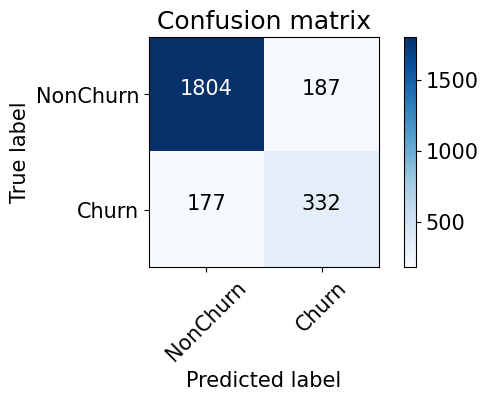

In [58]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_gb_params = confusion_matrix(y_test, preds_gb_params>thresholds_gb_params[ix_gb_params])
plt.figure(figsize=(6, 4))
plot_confusion_matrix(cnf_matrix_gb_params, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [59]:
# градиентный бустинг c параметрами
TN = cnf_matrix_gb_params[0][0]
FP = cnf_matrix_gb_params[0][1]
FN = cnf_matrix_gb_params[1][0]
TP = cnf_matrix_gb_params[1][1]

retain_sum_gb_params = (FP + TP) * 1
income_gb_params = TP * 2

income_gb_params - retain_sum_gb_params

145

После подбора гиперпарметров, данная новая модель  показала себя хуже, чем модель градиентного бустинга с параметрами по умолчанию (145 в последнем примере, а 175 в первом )